In [ ]:
! pip install wrds pandas

Loading library list...
Done


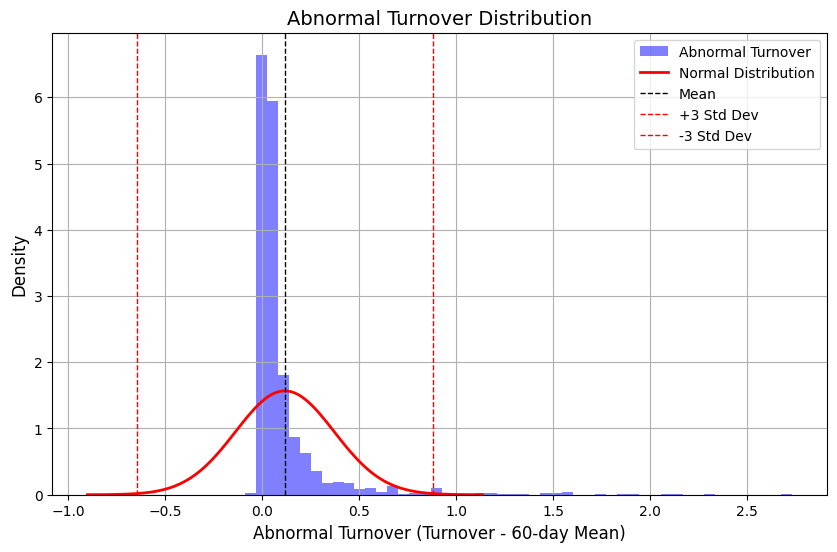

In [ ]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Connect to WRDS
conn = wrds.Connection()

# Query CRSP data (Daily Stock File + Shares Outstanding)
query_crsp = """
    SELECT dsf.permno, dsf.date, dsf.vol, dsf.prc, dse.shrout
    FROM crsp.dsf AS dsf
    LEFT JOIN crsp.dse AS dse
    ON dsf.permno = dse.permno AND dsf.date = dse.date
    WHERE dsf.date >= '2000-01-01'
"""
crsp_data = conn.raw_sql(query_crsp)

# Close WRDS connection
conn.close()

# Convert date to datetime format
crsp_data['date'] = pd.to_datetime(crsp_data['date'])

# Ensure price is positive (CRSP records bid/ask prices as negative)
crsp_data['prc'] = crsp_data['prc'].abs()

# Convert shares outstanding to actual shares (stored in thousands)
crsp_data['shrout'] = crsp_data['shrout'] * 1000

# Calculate turnover ratio (volume / shares outstanding)
crsp_data['turnover'] = crsp_data['vol'] / crsp_data['shrout']

# Compute rolling mean & standard deviation of turnover for each stock (PERMNO)
crsp_data['turnover_mean'] = crsp_data.groupby('permno')['turnover'].transform(lambda x: x.rolling(window=60, min_periods=30).mean())
crsp_data['turnover_std'] = crsp_data.groupby('permno')['turnover'].transform(lambda x: x.rolling(window=60, min_periods=30).std())

# Compute abnormal turnover
crsp_data['abnormal_turnover'] = crsp_data['turnover'] - crsp_data['turnover_mean']

# Identify turnover beyond ±3 standard deviations (Normal Curve Threshold)
crsp_data['turnover_z_score'] = (crsp_data['turnover'] - crsp_data['turnover_mean']) / crsp_data['turnover_std']
crsp_data['extreme_turnover'] = (crsp_data['turnover_z_score'].abs() > 3)

# Filter stock-days with extreme turnover
filtered_data = crsp_data[crsp_data['extreme_turnover']]

# Save filtered data to CSV
filtered_data.to_csv('filtered_turnover_stock_days.csv', index=False)

### PLOTTING: Abnormal Turnover Histogram with Normal Curve ###
# Compute mean and standard deviation of abnormal turnover
mu = np.mean(filtered_data['abnormal_turnover'].dropna())
sigma = np.std(filtered_data['abnormal_turnover'].dropna())

# Generate normal distribution curve
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

# Plot histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['abnormal_turnover'].dropna(), bins=50, density=True, alpha=0.5, color='blue', label='Abnormal Turnover')

# Plot normal distribution curve
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='red', linewidth=2, label='Normal Distribution')

# Plot ±3 standard deviation lines
plt.axvline(mu, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mu + 3*sigma, color='red', linestyle='dashed', linewidth=1, label='+3 Std Dev')
plt.axvline(mu - 3*sigma, color='red', linestyle='dashed', linewidth=1, label='-3 Std Dev')

# Labels and title
plt.title("Abnormal Turnover Distribution", fontsize=14)
plt.xlabel("Abnormal Turnover (Turnover - 60-day Mean)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid()

# Show the plot
plt.show()


ERROR: Could not find a version that satisfies the requirement seaborn (from versions: none)
ERROR: No matching distribution found for seaborn
